### Гауссов импульс

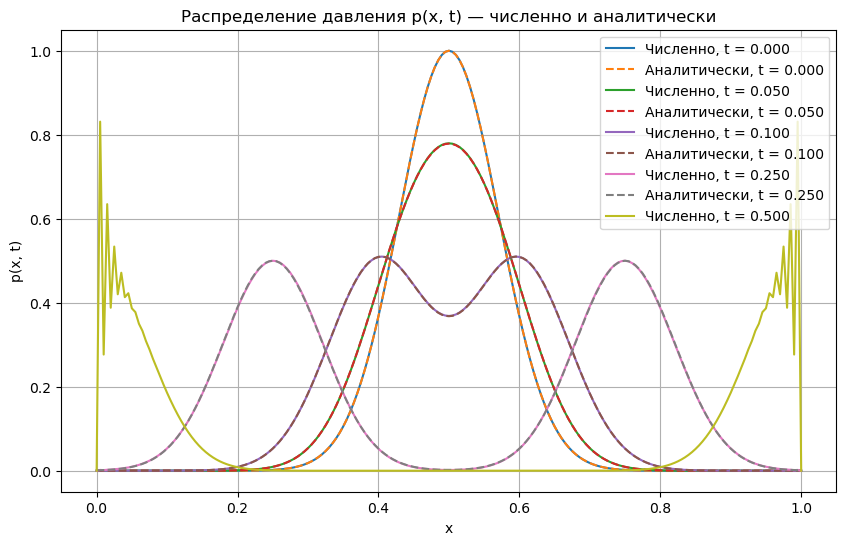

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
l = 1.0
T = 0.5
Nx = 200
Nt = 500
k = 1.0
rho = 1.0
c = np.sqrt(k / rho)

x = np.linspace(0, l, Nx + 1)
t = np.linspace(0, T, Nt + 1)
dx = l / Nx
dt = T / Nt

courant = c * dt / dx
assert courant <= 1.0, "Нарушено условие Куранта! Уменьшите dt или увеличьте dx."

u = np.zeros((Nt + 1, Nx + 1))  # скорость
p = np.zeros((Nt + 1, Nx + 1))  # давление

# Начальные условия: гауссов импульс давления
gauss = lambda x: np.exp(-100 * (x - l / 2)**2)
p[0] = gauss(x)
u[0] = np.zeros_like(x)

# Схема Лакса–Вендрофа
for n in range(Nt):
    for i in range(1, Nx):
        u[n+1, i] = u[n, i] \
                    - dt / (2 * rho * dx) * (p[n, i+1] - p[n, i-1]) \
                    + (dt**2) / (2 * rho * dx**2) * (k * (u[n, i+1] - 2 * u[n, i] + u[n, i-1]))
        
        p[n+1, i] = p[n, i] \
                    - dt * k / (2 * dx) * (u[n, i+1] - u[n, i-1]) \
                    + (dt**2 * k) / (2 * dx**2) * (1 / rho) * (p[n, i+1] - 2 * p[n, i] + p[n, i-1])

    u[n+1, 0] = u[n+1, -1] = 0
    p[n+1, 0] = p[n+1, -1] = 0

# === ДОБАВЛЕНИЕ АНАЛИТИЧЕСКОЙ КРИВОЙ ===
def p_exact(x, t, c):
    return 0.5 * (gauss(x - c * t) + gauss(x + c * t))

# Визуализация: давление и аналитическая кривая
plt.figure(figsize=(10, 6))
for time_index in [0, Nt//10, Nt//5, Nt//2, Nt]:
    time = t[time_index]
    plt.plot(x, p[time_index], label=f"Численно, t = {time:.3f}")
    
    if time < l / (2 * c):  # пока ещё не было отражений
        plt.plot(x, p_exact(x, time, c), '--', label=f"Аналитически, t = {time:.3f}")

plt.title("Распределение давления p(x, t) — численно и аналитически")
plt.xlabel("x")
plt.ylabel("p(x, t)")
plt.grid(True)
plt.legend()
plt.show()


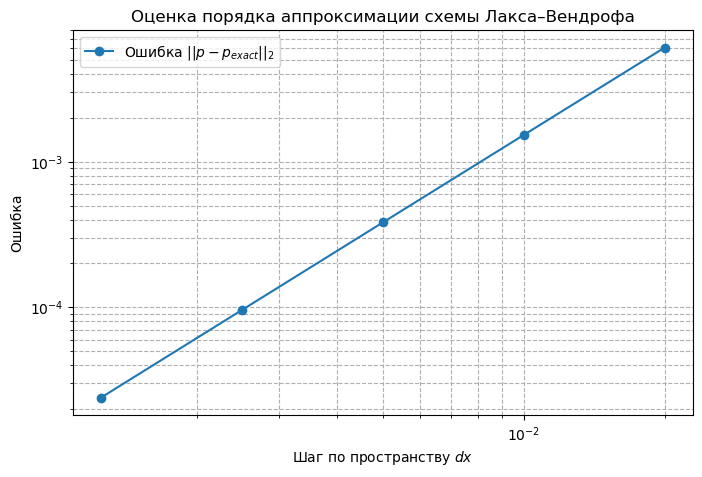

Порядок между Nx=50 и Nx=100: 1.99
Порядок между Nx=100 и Nx=200: 2.00
Порядок между Nx=200 и Nx=400: 2.00
Порядок между Nx=400 и Nx=800: 2.00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def solve_wave(Nx, Nt):
    l = 1.0
    T = 0.1
    k = 1.0
    rho = 1.0
    c = np.sqrt(k / rho)

    x = np.linspace(0, l, Nx + 1)
    t = np.linspace(0, T, Nt + 1)
    dx = l / Nx
    dt = T / Nt

    assert c * dt / dx <= 1.0, "Нарушено условие Куранта!"

    u = np.zeros((Nt + 1, Nx + 1))
    p = np.zeros((Nt + 1, Nx + 1))

    f = lambda x: np.exp(-100 * (x - l / 2) ** 2)
    p[0] = f(x)
    u[0] = 0

    for n in range(Nt):
        for i in range(1, Nx):
            u[n+1, i] = u[n, i] \
                        - dt / (2 * rho * dx) * (p[n, i+1] - p[n, i-1]) \
                        + (dt**2) / (2 * rho * dx**2) * (k * (u[n, i+1] - 2 * u[n, i] + u[n, i-1]))

            p[n+1, i] = p[n, i] \
                        - dt * k / (2 * dx) * (u[n, i+1] - u[n, i-1]) \
                        + (dt**2 * k) / (2 * dx**2) * (1 / rho) * (p[n, i+1] - 2 * p[n, i] + p[n, i-1])

        u[n+1, 0] = u[n+1, -1] = 0
        p[n+1, 0] = p[n+1, -1] = 0

    return x, p[-1], dx

# Аналитическое решение
def analytical_solution(x, T, c):
    f = lambda x: np.exp(-100 * (x - 0.5)**2)
    return 0.5 * (f(x - c*T) + f(x + c*T))

# Запуски для разных Nx
Nx_list = [50, 100, 200, 400, 800]
errors = []
dx_list = []

for Nx in Nx_list:
    Nt = 5 * Nx  # чтобы сохранить dt пропорциональным dx (устойчивость)
    x_num, p_num, dx = solve_wave(Nx, Nt)
    dx_list.append(dx)
    
    p_exact = analytical_solution(x_num, T=0.1, c=1.0)
    error = np.linalg.norm(p_num - p_exact) / np.sqrt(len(x_num))
    errors.append(error)

# Расчёт порядка по разностям
orders = np.log2(np.array(errors[:-1]) / np.array(errors[1:]))

# График ошибки
plt.figure(figsize=(8, 5))
plt.loglog(dx_list, errors, 'o-', label='Ошибка $||p - p_{exact}||_2$')
plt.grid(True, which="both", ls="--")
plt.xlabel("Шаг по пространству $dx$")
plt.ylabel("Ошибка")
plt.title("Оценка порядка аппроксимации схемы Лакса–Вендрофа")
plt.legend()
plt.show()

# Вывод порядка аппроксимации
for i in range(len(orders)):
    print(f"Порядок между Nx={Nx_list[i]} и Nx={Nx_list[i+1]}: {orders[i]:.2f}")


Для одномерной линейной акустики систему уравнений:

$$
\left\{
\begin{aligned}
\frac{\partial u}{\partial t} + \frac{1}{\rho} \frac{\partial p}{\partial x} &= 0, \\
\frac{\partial p}{\partial t} + k \frac{\partial u}{\partial x} &= 0
\end{aligned}
\right.
$$

$u(x, t)$ — скорость среды,

$p(x, t)$ — давление,

$\rho$ — плотность среды,

$k$ — модуль упругости.

можно преобразовать в инварианты Римана:

$$
w^\pm = p \pm Z u, \quad \text{где } Z = \sqrt{\rho k}
$$

Тогда система сводится к двум волновым уравнениям:

$$
\frac{\partial w^+}{\partial t} + c \frac{\partial w^+}{\partial x} = 0, \quad
\frac{\partial w^-}{\partial t} - c \frac{\partial w^-}{\partial x} = 0
$$

где $c = \sqrt{\frac{k}{\rho}}$ — скорость звука.

Схема Лакса–Вендрофа для $w^\pm$:

$$
w_i^{n+1} = w_i^n - \frac{\lambda}{2}(w_{i+1}^n - w_{i-1}^n)
+ \frac{\lambda^2}{2}(w_{i+1}^n - 2w_i^n + w_{i-1}^n),
\quad \text{где } \lambda = \pm c \cdot \frac{\Delta t}{\Delta x}
$$

Восстановливаем физические переменные:

$$
p_i = \frac{w_i^+ + w_i^-}{2}, \qquad
u_i = \frac{w_i^+ - w_i^-}{2Z}
$$


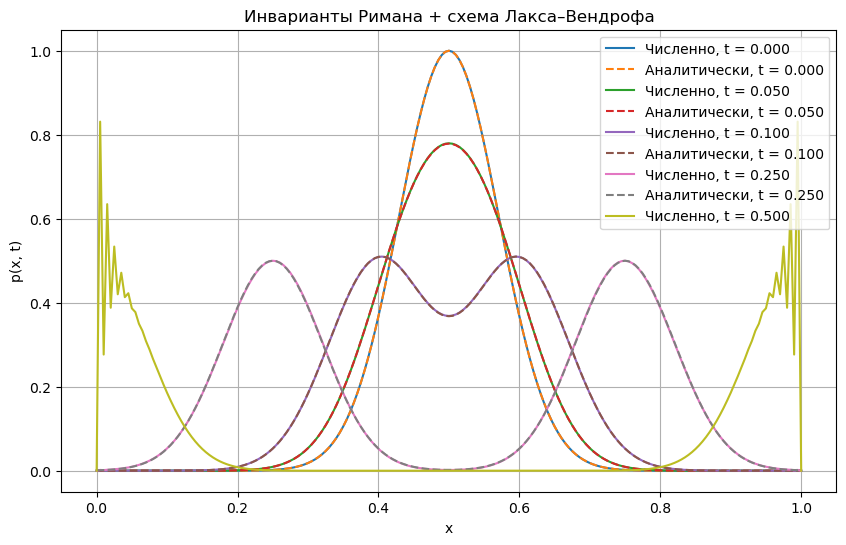

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
l = 1.0
T = 0.5
Nx = 200
Nt = 500
k = 1.0
rho = 1.0
c = np.sqrt(k / rho)
Z = np.sqrt(rho * k)

x = np.linspace(0, l, Nx + 1)
t = np.linspace(0, T, Nt + 1)
dx = l / Nx
dt = T / Nt
lambda_c = c * dt / dx

assert lambda_c <= 1.0, "Нарушено условие Куранта!"

# Гауссов импульс
gauss = lambda x: np.exp(-100 * (x - l/2)**2)
p0 = gauss(x)
u0 = np.zeros_like(x)

# Инварианты Римана
w_plus = p0 + Z * u0
w_minus = p0 - Z * u0

# Инициализация
w_plus_arr = np.zeros((Nt + 1, Nx + 1))
w_minus_arr = np.zeros((Nt + 1, Nx + 1))
p_arr = np.zeros((Nt + 1, Nx + 1))
u_arr = np.zeros((Nt + 1, Nx + 1))

w_plus_arr[0] = w_plus
w_minus_arr[0] = w_minus
p_arr[0] = p0
u_arr[0] = u0

# Схема Лакса–Вендрофа
def lax_wendroff(w, lambd):
    w_new = np.zeros_like(w)
    w_new[1:-1] = w[1:-1] \
        - lambd / 2 * (w[2:] - w[:-2]) \
        + lambd**2 / 2 * (w[2:] - 2 * w[1:-1] + w[:-2])
    return w_new

# Расчёт по времени
for n in range(Nt):
    w_plus_arr[n+1] = lax_wendroff(w_plus_arr[n], +lambda_c)
    w_minus_arr[n+1] = lax_wendroff(w_minus_arr[n], -lambda_c)

    # Границы: u=0 => w+ = w-
    w_plus_arr[n+1, 0] = w_minus_arr[n+1, 0]
    w_minus_arr[n+1, -1] = w_plus_arr[n+1, -1]

    p_arr[n+1] = 0.5 * (w_plus_arr[n+1] + w_minus_arr[n+1])
    u_arr[n+1] = 0.5 * (w_plus_arr[n+1] - w_minus_arr[n+1]) / Z

# Аналитическое решение
def p_exact(x, t, c):
    return 0.5 * (gauss(x - c * t) + gauss(x + c * t))

# Визуализация
plt.figure(figsize=(10, 6))
for time_index in [0, Nt//10, Nt//5, Nt//2, Nt]:
    time = t[time_index]
    plt.plot(x, p_arr[time_index], label=f"Численно, t = {time:.3f}")

    if time < l / (2 * c):  # до отражений
        plt.plot(x, p_exact(x, time, c), '--', label=f"Аналитически, t = {time:.3f}")

plt.title("Инварианты Римана + схема Лакса–Вендрофа")
plt.xlabel("x")
plt.ylabel("p(x, t)")
plt.grid(True)
plt.legend()
plt.show()


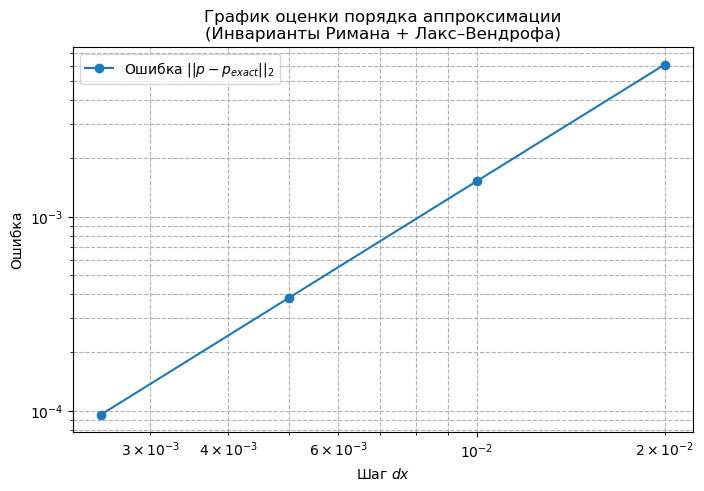

Порядок между Nx=50 и Nx=100: 1.99
Порядок между Nx=100 и Nx=200: 2.00
Порядок между Nx=200 и Nx=400: 2.00


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def solve_riemann_lw(Nx, Nt, T=0.1):
    l = 1.0
    k = 1.0
    rho = 1.0
    c = np.sqrt(k / rho)
    Z = np.sqrt(rho * k)

    x = np.linspace(0, l, Nx + 1)
    t = np.linspace(0, T, Nt + 1)
    dx = l / Nx
    dt = T / Nt
    lambda_c = c * dt / dx
    assert lambda_c <= 1.0

    gauss = lambda x: np.exp(-100 * (x - l/2)**2)
    p0 = gauss(x)
    u0 = np.zeros_like(x)
    w_plus = p0 + Z * u0
    w_minus = p0 - Z * u0

    def lax_wendroff(w, lambd):
        w_new = np.zeros_like(w)
        w_new[1:-1] = w[1:-1] \
            - lambd / 2 * (w[2:] - w[:-2]) \
            + lambd**2 / 2 * (w[2:] - 2 * w[1:-1] + w[:-2])
        return w_new

    for _ in range(Nt):
        w_plus = lax_wendroff(w_plus, +lambda_c)
        w_minus = lax_wendroff(w_minus, -lambda_c)
        w_plus[0] = w_minus[0]
        w_minus[-1] = w_plus[-1]

    p = 0.5 * (w_plus + w_minus)
    return x, p, dx

def p_exact(x, T, c=1.0):
    return 0.5 * (np.exp(-100 * (x - 0.5 - c*T)**2) + np.exp(-100 * (x - 0.5 + c*T)**2))

# Параметры
Nx_list = [50, 100, 200, 400]
errors = []
dx_list = []

for Nx in Nx_list:
    Nt = 5 * Nx
    x_num, p_num, dx = solve_riemann_lw(Nx, Nt, T=0.1)
    dx_list.append(dx)
    p_ex = p_exact(x_num, T=0.1)
    error = np.linalg.norm(p_num - p_ex) / np.sqrt(len(x_num))
    errors.append(error)

# Расчёт порядков
orders = np.log2(np.array(errors[:-1]) / np.array(errors[1:]))

# График
plt.figure(figsize=(8, 5))
plt.loglog(dx_list, errors, 'o-', label='Ошибка $||p - p_{exact}||_2$')
plt.xlabel('Шаг $dx$')
plt.ylabel('Ошибка')
plt.title('График оценки порядка аппроксимации\n(Инварианты Римана + Лакс–Вендрофа)')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

# Вывод
for i in range(len(orders)):
    print(f"Порядок между Nx={Nx_list[i]} и Nx={Nx_list[i+1]}: {orders[i]:.2f}")
